In [1]:
import os
import torch
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re
import importlib

import h5py
from scipy.ndimage import zoom

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns #import automapRecon
import unrolling_fns
import swin_fns

/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
2025-11-05 10:07:41.728058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 10:07:42.452083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__nam

## Importing Phantom Data

In [3]:
filename = 'data/phantom_data_75_64_25_2.mat'
data = loadmat(filename)

In [4]:
kspGT = np.moveaxis(data['i_kspace_NA256'],3,0)

In [5]:
kspGT = kspGT[0,:,:,:]+1j*kspGT[1,:,:,:]
kspGT = kspGT[np.newaxis,:]

## Scaling data

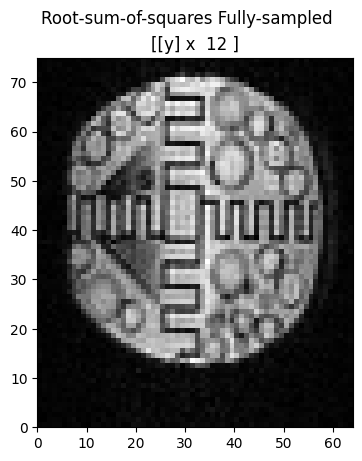

In [6]:
# stock standard recon to get an appropriate scaling factor for the ksp data
img_rss = np.sum(np.abs(sp.ifft(kspGT, axes=(-1, -2, -3)))**2, axis=0)**0.5
volumeGTrss = img_rss

pl.ImagePlot(img_rss, x=1,y=0,title='Root-sum-of-squares Fully-sampled')

# scaling all numbers to sensible values from the beginning
scale_factor = np.percentile(abs(volumeGTrss),95) 
kspGTscaled = kspGT/scale_factor

yshift = -2
kspGTscaled = np.roll(kspGTscaled,(0,yshift,0),axis=(1,2,3))

#kspNA32scaled = kspGTscaled

kspNA256scaled = np.moveaxis(data['i_kspace_NA256'],3,0)/scale_factor*8
kspNA256scaled = np.roll(kspNA256scaled,(0,yshift,0),axis=(1,2,3))

kspNA32scaled = np.moveaxis(data['i_kspace_NA32'],3,0)/scale_factor*256/32
kspNA32scaled = np.roll(kspNA32scaled,(0,yshift,0),axis=(1,2,3))

kspNA16scaled = np.moveaxis(data['i_kspace_NA16'],3,0)/scale_factor*256/16
kspNA16scaled = np.roll(kspNA16scaled,(0,yshift,0),axis=(1,2,3))

kspNA8scaled = np.moveaxis(data['i_kspace_NA8'],3,0)/scale_factor*256/8
kspNA8scaled = np.roll(kspNA8scaled,(0,yshift,0),axis=(1,2,3))

kspNA4scaled = np.moveaxis(data['i_kspace_NA4'],3,0)/scale_factor*256/4
kspNA4scaled = np.roll(kspNA4scaled,(0,yshift,0),axis=(1,2,3))

if kspGTscaled.shape[0] == 1:
    mps = np.ones(kspGTscaled.shape,dtype=complex)
else:
    mps = mr.app.EspiritCalib(kspGTscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
    #mps = mr.app.JsenseRecon(kspGTscaled, ksp_calib_width=20, mps_ker_width=6, show_pbar=True).run()
#mps = np.ones(kspGTscaled.shape)
img_fs = sp.ifft(kspGTscaled, axes=(-1, -2, -3))
volumeGTscaled = coil_combine(img_fs,mps)

In [7]:
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.15))

volumeGTscaledmasked = np.copy(volumeGTscaled)
volumeGTscaledmasked[mask_metrics]=0

kspTestScaled = kspNA32scaled #kspGTscaled

#optional recentering of k-space to correct phase map
delta_x = 0
delta_y = 0
delta_z = 0
kspTestScaled = np.roll(kspTestScaled,(delta_x,delta_y,delta_z),axis=(1,2,3)) 

## Input data

## R=2 Calcs

In [8]:
R = 2 # acceleration factor
calib_size = 10

loss_fn = 'mse'
#loss_fn = 'perceptual'


In [9]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'

### Poisson Disc Mask

In [10]:

# defining PD mask
imSize = np.array(img_rss.shape)

in_seed = 0#randrange(100)
if R==1:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)  
elif R==2:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
elif R==4:
  mask = poissonDiscSigpy(imSize,R+0.5, in_seed,calib_size)  
mask.shape

1/np.mean(abs(mask)) #true R value


1.9389865563598758

In [11]:
mask.shape

(75, 25)

## Masking and Reconstructing Data

In [12]:
#kspInput = kspGTscaled

#kspInput = kspNA32scaled
kspInput = kspNA16scaled
kspInput = kspInput[0,:,:,:]+1j*kspInput[1,:,:,:]
kspInput = kspInput[np.newaxis,:]
NAstr = ' '


In [13]:
uskspace = applyMask(kspInput,mask)

In [14]:
import time

no_masks = 1
lamda_opt=0.05
iter_opt = 25
lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=False)

start_time = time.time()
volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)
print(f"CS recon time: {time.time() - start_time:.2f} s")

volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

CS recon time: 0.64 s


In [15]:
importlib.reload(unrolling_fns)
importlib.reload(swin_fns)

<module 'swin_fns' from '/home/david/repos/Low_Field_MRI_Recon/swin_fns.py'>

In [16]:
uskspace = np.roll(kspInput,(0,0,0),axis=(1,2,3)) 
uskspace = applyMask(uskspace,mask)

start_time = time.time()
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace,mask,mps,unroll_model_pth)
print(f"Unroll recon time: {time.time() - start_time:.2f} s")

start_time = time.time()
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace,mps,model_real_dir,model_imag_dir)
print(f"Amap recon time: {time.time() - start_time:.2f} s")

start_time = time.time()
model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
volswinrecon, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device)
print(f"Swin Cascade recon time: {time.time() - start_time:.2f} s")

Unroll recon time: 1.43 s


2025-11-05 10:08:28.340949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45803 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6
2025-11-05 10:08:28.342280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47173 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2025-11-05 10:08:31.155370: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


Amap recon time: 4.14 s


/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Swin Cascade recon time: 9.98 s


In [18]:
start_time = time.time()
volswinrecon, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device)
print(f"Swin Cascade recon time: {time.time() - start_time:.2f} s")

Swin Cascade recon time: 8.21 s


## NEX 256 as reference

In [19]:
volumeGTscaled_NA256 = np.copy(volumeGTscaled)
volumeGTscaledmasked_NA256 = np.copy(volumeGTscaled)
volumeGTscaledmasked_NA256[mask_metrics]=0
vol1 = np.copy(volifftrecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nNA = 16'+NAstr+'\nR = '+str(R)
vol2 = np.copy(volcsrecon)
vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nNA = '+NAstr+'\nR = '+str(R)
vol3 = np.copy(volamaprecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nNA = '+NAstr+'\nR = '+str(R)
vol4 = np.copy(volunrollrecon)
vol4[mask_metrics]=0
vol4title = 'Unrolling\nNA = '+NAstr+'\nR = '+str(R)
vol5 = np.copy(volswinrecon)
vol5[mask_metrics]=0
vol5title = 'Swin\nNA = '+NAstr+'\nR = '+str(R)

vol1_R2 = vol1
vol2_R2 = vol2
vol3_R2 = vol3
vol4_R2 = vol4
vol5_R2 = vol5

slc = 17

In [20]:
volumeGTscaledmasked_NA16 = np.copy(sp.ifft(kspInput[0,:,:,:],axes=[1,2,3]))
volumeGTscaled_NA16 = volumeGTscaledmasked_NA16
volumeGTscaledmasked_NA16[mask_metrics]=0

In [21]:
import numpy as np

def brisque_volume_3d(
    volume: np.ndarray,
    axis: int = -1,
    clip_percentiles: tuple | None = None,
    auto_pad_min: int = 32,
):
    """
    Compute slice-wise BRISQUE on a 3D MRI volume and average along a chosen axis.
    Uses PIQ's BRISQUE implementation. Pads only when a slice is smaller than `auto_pad_min`
    in either spatial dimension (prints once per volume when padding occurs).

    Parameters
    ----------
    volume : np.ndarray
        3D complex or real array, shape (D, H, W) in any orientation.
        If complex, the magnitude (np.abs) is used.
    axis : int, default -1
        Axis along which to take slices/average (0, 1, or 2).
    clip_percentiles : (float, float) or None
        Optional robust intensity clipping before normalization, e.g. (1, 99).
    auto_pad_min : int, default 32
        Minimum spatial size (height/width) required; slices smaller than this
        are zero-padded to reach it.

    Returns
    -------
    mean_score : float
        Mean BRISQUE across valid slices (lower = better).
    std_score : float
        Standard deviation across valid slices.
    per_slice_scores : np.ndarray
        BRISQUE for each slice (np.nan where invalid).
    """
    # --- imports (kept inside so your module doesn't hard-require torch/piq on import) ---
    try:
        import torch
        import piq
    except Exception as e:
        raise ImportError(
            "This function requires PyTorch and PIQ. Install with:\n"
            "  pip install torch piq\n"
            f"Original import error: {e}"
        )

    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {volume.shape}")

    # Complex->magnitude and float32
    vol = np.abs(volume).astype(np.float32)

    # Optional robust clipping (helps with outliers at low field)
    if clip_percentiles is not None:
        p_lo, p_hi = np.percentile(vol, clip_percentiles)
        if p_hi > p_lo:
            vol = np.clip(vol, p_lo, p_hi)

    # Global min-max normalization to [0,1]
    vmin, vmax = float(np.nanmin(vol)), float(np.nanmax(vol))
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
        S = vol.shape[axis]
        return np.nan, np.nan, np.full(S, np.nan, dtype=float)
    vol = (vol - vmin) / (vmax - vmin + 1e-12)

    # Reorder so chosen axis is first: (S, H, W)
    vol_slices = np.moveaxis(vol, axis, 0)
    S = vol_slices.shape[0]
    scores = np.full(S, np.nan, dtype=float)

    padded_once = False

    for i in range(S):
        sl = vol_slices[i]
        if sl.ndim != 2 or sl.size == 0 or not np.isfinite(sl).all():
            continue
        if sl.max() <= sl.min():
            continue

        h, w = sl.shape
        if h < auto_pad_min or w < auto_pad_min:
            pad_h = max(0, auto_pad_min - h)
            pad_w = max(0, auto_pad_min - w)
            sl = np.pad(sl, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
            if not padded_once:
                print(f"[BRISQUE] Zero-padded small slices to reach at least {auto_pad_min}×{auto_pad_min} (once per volume).")
                padded_once = True

        # PIQ expects torch tensor NCHW in [0,1]
        x = torch.from_numpy(sl).float().unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
        try:
            scores[i] = float(piq.brisque(x))
        except Exception:
            # If BRISQUE fails on a pathological slice, leave NaN
            pass

    valid = np.isfinite(scores)
    if not np.any(valid):
        return np.nan, np.nan, scores
    return float(np.nanmean(scores[valid])), float(np.nanstd(scores[valid])), scores


In [22]:
import numpy as np
import sigpy as sp

def kce_rel_to_zf(x_hat, x_ref, mask_pe1pe2, eps=1e-12):
    """
    K-space Hold-out RMSE (KHE):
    Computes RMSE of the reconstructed vs. reference k-space
    values only within the unacquired (held-out) region.

    Formula:
        KHE = || (1 - M) * (F{x_hat} - F{x_ref}) ||_2 / || (1 - M) * F{x_ref} ||_2

    Args:
        x_hat (ndarray): Reconstructed complex image [PE1, RO, PE2].
        x_ref (ndarray): Fully-sampled reference complex image [PE1, RO, PE2].
        mask_pe1pe2 (ndarray): 2D undersampling mask over (PE1, PE2),
                               1 = acquired, 0 = missing / held-out.
        eps (float): Small value to prevent divide-by-zero.

    Returns:
        float: Normalized RMSE of k-space values in the unacquired region.
    """
    PE1, RO, PE2 = x_ref.shape
    assert mask_pe1pe2.shape == (PE1, PE2), f"mask must be shape {(PE1, PE2)}"

    # Expand (PE1, PE2) → (PE1, RO, PE2)
    M3d = np.repeat(mask_pe1pe2.astype(np.uint8)[:, None, :], RO, axis=1)

    # Compute centered FFTs (unitary for consistent energy)
    Y_ref = sp.fft(x_ref, axes=(0, 2), center=True, norm='ortho')
    Y_hat = sp.fft(x_hat, axes=(0, 2), center=True, norm='ortho')

    # Restrict to unacquired (held-out) k-space region
    diff = (1 - M3d) * (Y_hat - Y_ref)
    ref_band = (1 - M3d) * Y_ref

    num = np.linalg.norm(diff.ravel())
    den = np.linalg.norm(ref_band.ravel()) + eps

    return float(num / den)


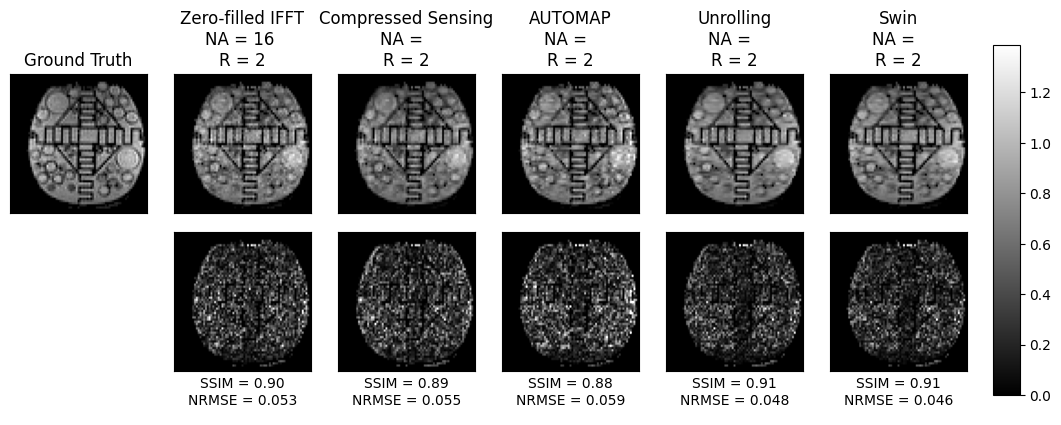

Difference Maps are scaled by 3


In [23]:
import importlib
import display_fns  # or your full module path if needed, e.g., pt_Unrolling.SwinCascade.swin_recon_3d

importlib.reload(display_fns)

from display_fns import compare_n_plot

fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked_NA256,
    volumes=[vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

#fig_comp.savefig('export_figs/hidden_noise_NA256.pdf', bbox_inches='tight', dpi=300)

In [24]:
def plot_phase_grid(volumes_cplx, titles, slc, mask_frac=0.05, view='cor'):
    """
    Plot phase maps for a chosen anatomical view from complex volumes.

    Args:
        volumes_cplx (list of np.ndarray): complex 3D volumes [PE1, RO, PE2]
        titles (list of str): same length as volumes
        slc (int): slice index along chosen view axis
        mask_frac (float): mask pixels below this fraction of max |x|
        view (str): 'ax' (default, axis=1), 'sag' (axis=0), or 'cor' (axis=2)
    """
    assert len(volumes_cplx) == len(titles)
    axis_map = {'sag': 0, 'ax': 1, 'cor': 2}
    axid = axis_map.get(view.lower(), 1)

    n = len(volumes_cplx)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True)
    axes = np.atleast_2d(axes)

    vmin, vmax = -np.pi, np.pi

    for i, (vol, title) in enumerate(zip(volumes_cplx, titles)):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        if not np.iscomplexobj(vol):
            ax.axis('off')
            ax.set_title(f"{title}\n(no complex phase)")
            continue

        sl = np.take(vol, indices=slc, axis=axid)
        mag = np.abs(sl)
        phase = np.angle(sl)
        thr = mag.max() * mask_frac
        phase_masked = np.ma.masked_where(mag < thr, phase)

        im = ax.imshow(phase_masked, cmap='twilight', vmin=vmin, vmax=vmax, origin='lower')
        ax.set_title(f"{title}\n({view.upper()})", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])

    # colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Phase [rad] (−π … π)')

    return fig





In [25]:
import numpy as np

def flatten_phase_linear_3d(vol_c, target_c=None, mask_frac=0.05, eps=1e-12, axes="all",
                            max_iters=50, step=0.1, weight_power=1.0, mask_schedule=None, tol=1e-6):
    assert np.iscomplexobj(vol_c) and vol_c.ndim == 3
    if target_c is not None:
        assert target_c.shape == vol_c.shape and np.iscomplexobj(target_c)

    P, R, E = vol_c.shape
    i, j, k = np.indices((P, R, E)).astype(np.float64)
    # CENTERED COORDS (must match apply_phase_ramp_3d)
    i -= (P - 1)/2; j -= (R - 1)/2; k -= (E - 1)/2

    fit_axes = {0,1,2} if axes == "all" else set(axes)
    use_a = 1 if 0 in fit_axes else 0
    use_b = 1 if 1 in fit_axes else 0
    use_c = 1 if 2 in fit_axes else 0

    # cumulative params we actually APPLY
    a_cum = 0.0; b_cum = 0.0; c_cum = 0.0; d_cum = 0.0

    def one_fit(vol_now):
        # phase difference (align to target) or absolute phase
        if target_c is None:
            ph = np.angle(vol_now); mag = np.abs(vol_now)
        else:
            ph = np.angle(vol_now * np.conj(target_c))
            mag = np.minimum(np.abs(vol_now), np.abs(target_c))

        thr = mag.max() * mask_frac
        msk = (mag >= thr)
        if not np.any(msk):  # nothing reliable
            return 0.0, 0.0, 0.0, 0.0, 0.0

        # unwrap (sequential 3D unwrap)
        phu = np.unwrap(np.unwrap(np.unwrap(ph, axis=0), axis=1), axis=2)

        I = i[msk]; J = j[msk]; K = k[msk]
        Y = phu[msk].astype(np.float64)
        W = (mag[msk].astype(np.float64) + eps)**weight_power

        cols = []
        if use_a: cols.append(I)
        if use_b: cols.append(J)
        if use_c: cols.append(K)
        cols.append(np.ones_like(I))
        X = np.stack(cols, axis=1)

        WX = X * W[:, None]
        H = WX.T @ X
        rhs = WX.T @ Y
        try:
            theta = np.linalg.solve(H, rhs)
        except np.linalg.LinAlgError:
            theta, *_ = np.linalg.lstsq(H, rhs, rcond=None)

        idx = 0
        a = float(theta[idx]) if use_a else 0.0; idx += use_a
        b = float(theta[idx]) if use_b else 0.0; idx += use_b
        c = float(theta[idx]) if use_c else 0.0; idx += use_c
        d = float(theta[idx])
        # RMS residual (for convergence check)
        res = Y - X @ theta
        rmse = float(np.sqrt((W * res**2).sum() / (W.sum() + eps)))
        return a, b, c, d, rmse

    vol = vol_c.copy()
    last_rmse = None

    msched = mask_schedule or []
    sched = list(msched) + [mask_frac] * max(0, max_iters - len(msched))

    for it in range(max_iters):
        mask_frac = sched[it] if it < len(sched) else mask_frac
        a, b, c, d, rmse = one_fit(vol)

        # small-step application
        a_step, b_step, c_step, d_step = step*a, step*b, step*c, step*d
        ramp = np.exp(-1j * (a_step*i + b_step*j + c_step*k + d_step))
        vol *= ramp

        # accumulate exactly what we applied
        a_cum += a_step; b_cum += b_step; c_cum += c_step; d_cum += d_step

        if last_rmse is not None and abs(last_rmse - rmse) < tol:
            break
        last_rmse = rmse

    params_cum = dict(a=a_cum, b=b_cum, c=c_cum, d=d_cum)
    return vol, params_cum

import numpy as np

def apply_phase_ramp_3d(vol_c, params, inverse=True):
    """
    Apply (or reapply) a global 3D linear phase ramp to a complex volume.

    Phase model:  φ(x,y,z) = a*x + b*y + c*z + d

    Args:
        vol_c  : complex np.ndarray, shape [PE1, RO, PE2]
        params : dict with keys 'a', 'b', 'c', 'd' (radians per voxel)
                 e.g. from flatten_phase_linear_3d(...)[1]
        inverse: if True (default), applies the *removal* ramp exp(-iφ)
                 if False, applies the *forward* ramp exp(+iφ)

    Returns:
        vol_out : complex np.ndarray, same shape as input
    """
    assert np.iscomplexobj(vol_c) and vol_c.ndim == 3, "vol_c must be a complex 3D array"
    a, b, c, d = [params.get(k, 0.0) for k in ('a','b','c','d')]

    # Center coordinates (matching the same convention used in flatten_phase_linear_3d)
    P, R, E = vol_c.shape
    i, j, k = np.indices((P, R, E)).astype(np.float64)
    i -= (P - 1) / 2
    j -= (R - 1) / 2
    k -= (E - 1) / 2

    # Construct global phase term
    phi = a * i + b * j + c * k + d
    sign = -1.0 if inverse else 1.0
    ramp = np.exp(1j * sign * phi)

    return vol_c * ramp


Residual slopes: {'a': 0.016913950923453033, 'b': 0.016778028780254212, 'c': -0.0009512279207105938, 'd': -2.781816248043283}


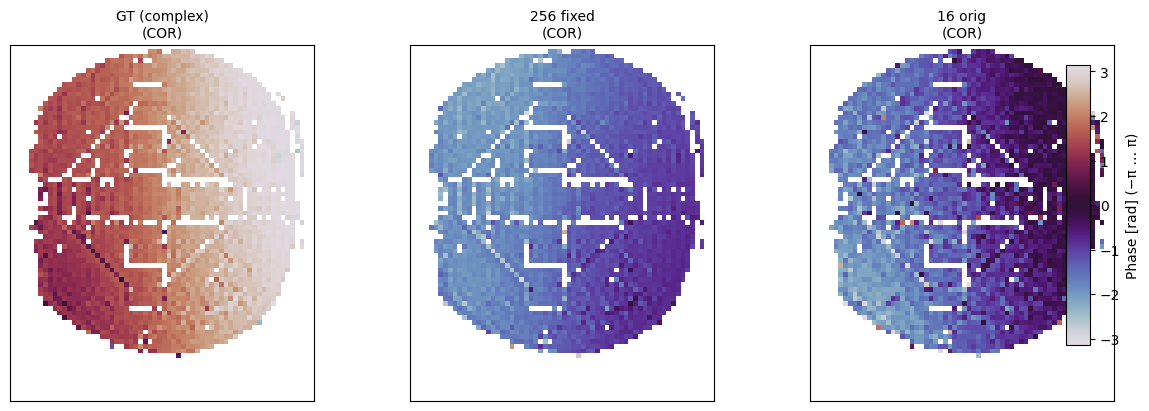

In [26]:

volumeGTscaledmasked_NA256f, params = flatten_phase_linear_3d(
    volumeGTscaledmasked_NA256,
    target_c=volumeGTscaledmasked_NA16,   # optional reference
    mask_frac=0.08,                       # start slightly higher to trust only strong signal
    max_iters=100,                         # slow refinement
    step=0.1,                             # small correction per iteration (10%)
    weight_power=2.0,                     # emphasize strong voxels (|mag|^2 weighting)
    mask_schedule=[0.08, 0.07, 0.06, 0.05, 0.04, 0.03],  # gradually include weaker voxels
    tol=1e-6                              # strict convergence
)

print("Residual slopes:", params)


volumeGTscaled_NA256f = apply_phase_ramp_3d(volumeGTscaled_NA256, params, inverse=True)

# === Your specific call ===
vols_c = [volumeGTscaledmasked_NA256, volumeGTscaledmasked_NA256f, volumeGTscaledmasked_NA16]
titles = ["GT (complex)", '256 fixed', '16 orig']

fig_phase = plot_phase_grid(vols_c, titles, slc=slc, mask_frac=0.01)
# fig_phase.savefig(f'export_figs/phase_maps_slice{slc:03d}.pdf', bbox_inches='tight', dpi=300)
plt.show()

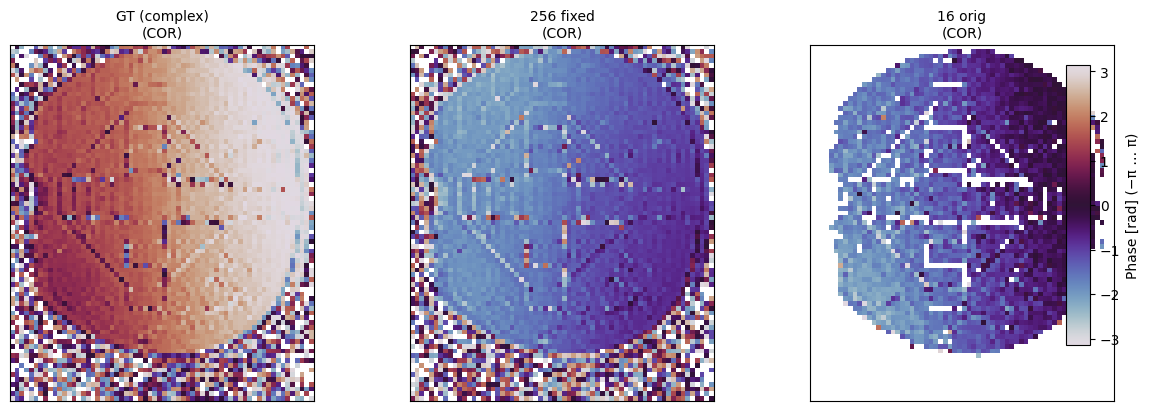

In [27]:
# === Your specific call ===
vols_c = [volumeGTscaled_NA256, volumeGTscaled_NA256f, volumeGTscaled_NA16]
titles = ["GT (complex)", '256 fixed', '16 orig']

fig_phase = plot_phase_grid(vols_c, titles, slc=slc, mask_frac=0.01)
# fig_phase.savefig(f'export_figs/phase_maps_slice{slc:03d}.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [28]:
# Example prints
print("\n--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---")
print(f"KCE_rel (Zero-fill):           {kce_rel_to_zf(volifftrecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (Compressed Sensing):  {kce_rel_to_zf(volcsrecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (AUTOMAP):             {kce_rel_to_zf(volamaprecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (Unrolled Network):    {kce_rel_to_zf(volunrollrecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (Swin):                {kce_rel_to_zf(volswinrecon, volumeGTscaled_NA256f, mask):.4f}")


--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---
KCE_rel (Zero-fill):           1.0000
KCE_rel (Compressed Sensing):  0.9480
KCE_rel (AUTOMAP):             1.0891
KCE_rel (Unrolled Network):    0.8297
KCE_rel (Swin):                0.7693


/tmp/ipykernel_1644278/3785520187.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M3d = np.repeat(mask_pe1pe2.astype(np.uint8)[:, None, :], RO, axis=1)


In [29]:
mean_b_ax, std_b_ax, per_ax = brisque_volume_3d(volifftrecon, axis=2)

In [30]:
mean_b_ax

32.9160498046875

## NEX 16 as reference

In [31]:
volumeGTscaledmasked_NA16 = np.copy(sp.ifft(kspInput[0,:,:,:],axes=[1,2,3]))
volumeGTscaled_NA16 = volumeGTscaledmasked_NA16
volumeGTscaledmasked_NA16[mask_metrics]=0

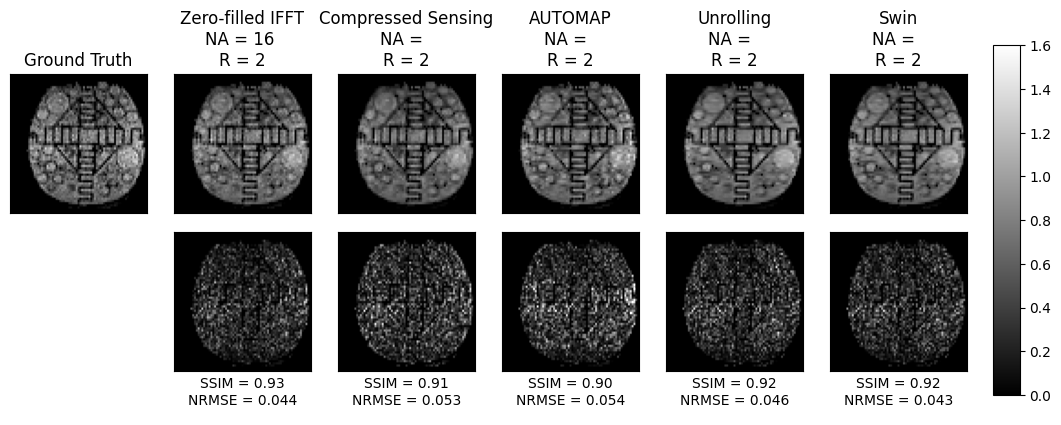

Difference Maps are scaled by 3


In [32]:
import importlib
import display_fns  # or your full module path if needed, e.g., pt_Unrolling.SwinCascade.swin_recon_3d

importlib.reload(display_fns)

from display_fns import compare_n_plot



fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked_NA16,
    volumes=[vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

fig_comp.savefig('export_figs/hidden_noise_NA16.pdf', bbox_inches='tight', dpi=300)

In [33]:
# Example prints
print("\n--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---")
print(f"KCE_rel (Zero-fill):           {kce_rel_to_zf(volifftrecon, volumeGTscaled_NA16, mask):.4f}")
print(f"KCE_rel (Compressed Sensing):  {kce_rel_to_zf(volcsrecon, volumeGTscaled_NA16, mask):.4f}")
print(f"KCE_rel (AUTOMAP):             {kce_rel_to_zf(volamaprecon, volumeGTscaled_NA16, mask):.4f}")
print(f"KCE_rel (Unrolled Network):    {kce_rel_to_zf(volunrollrecon, volumeGTscaled_NA16, mask):.4f}")
print(f"KCE_rel (Swin):                {kce_rel_to_zf(volswinrecon, volumeGTscaled_NA16, mask):.4f}")


--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---
KCE_rel (Zero-fill):           1.0000
KCE_rel (Compressed Sensing):  0.9310
KCE_rel (AUTOMAP):             1.0143
KCE_rel (Unrolled Network):    0.8103
KCE_rel (Swin):                0.7624


/tmp/ipykernel_1644278/3785520187.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M3d = np.repeat(mask_pe1pe2.astype(np.uint8)[:, None, :], RO, axis=1)


In [34]:
# # === Your specific call ===
# vols_c = [volumeGTscaledmasked_NA16, vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2]
# titles = ["GT (complex)", vol1title, vol2title, vol3title, vol4title, vol5title]

# fig_phase = plot_phase_grid(vols_c, titles, slc=slc, mask_frac=0.05)
# # fig_phase.savefig(f'export_figs/phase_maps_slice{slc:03d}.pdf', bbox_inches='tight', dpi=300)
# plt.show()

# NEX=8

In [35]:
# volumeGTscaledmasked = np.copy(sp.ifft(kspGTscaled[0,:,:,:],axes=[1,2,3]))
# volumeGTscaled = volumeGTscaledmasked

#kspInput = kspGTscaled

#kspInput = kspNA32scaled
kspInput = kspNA8scaled
kspInput = kspInput[0,:,:,:]+1j*kspInput[1,:,:,:]
kspInput = kspInput[np.newaxis,:]
NAstr = ' '

volumeGTscaledmasked_NA8 = np.copy(sp.ifft(kspInput[0,:,:,:],axes=[1,2,3]))
volumeGTscaled_NA8 = volumeGTscaledmasked_NA8
volumeGTscaledmasked_NA8[mask_metrics]=0

In [36]:
uskspace = applyMask(kspInput,mask)

In [37]:
no_masks = 1
lamda_opt=0.05
iter_opt = 25
lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=False)
volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)

volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

In [38]:
uskspace = np.roll(kspInput,(0,0,0),axis=(1,2,3)) 
uskspace = applyMask(uskspace,mask)

amap_scale = 1#0.01
unroll_scale = 1
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace,mask,mps,unroll_model_pth)
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

In [39]:
model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
volswinrecon, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device)

## NEX 256 as reference

In [40]:
volumeGTscaledmasked_NA256 = np.copy(volumeGTscaled_NA256)
volumeGTscaledmasked_NA256[mask_metrics]=0
vol1 = np.copy(volifftrecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nNA = 8'+NAstr+'\nR = '+str(R)
vol2 = np.copy(volcsrecon)
vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nNA = '+NAstr+'\nR = '+str(R)
vol3 = np.copy(volamaprecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nNA = '+NAstr+'\nR = '+str(R)
vol4 = np.copy(volunrollrecon)
vol4[mask_metrics]=0
vol4title = 'Unrolling\nNA = '+NAstr+'\nR = '+str(R)
vol5 = np.copy(volswinrecon)
vol5[mask_metrics]=0
vol5title = 'Swin\nNA = '+NAstr+'\nR = '+str(R)

vol1_R2 = vol1
vol2_R2 = vol2
vol3_R2 = vol3
vol4_R2 = vol4
vol5_R2 = vol5

slc = 17

Residual slopes: {'a': -0.0019560184852482516, 'b': 0.0014969365760062966, 'c': -0.0007627300535378903, 'd': 1.1148276830243253}


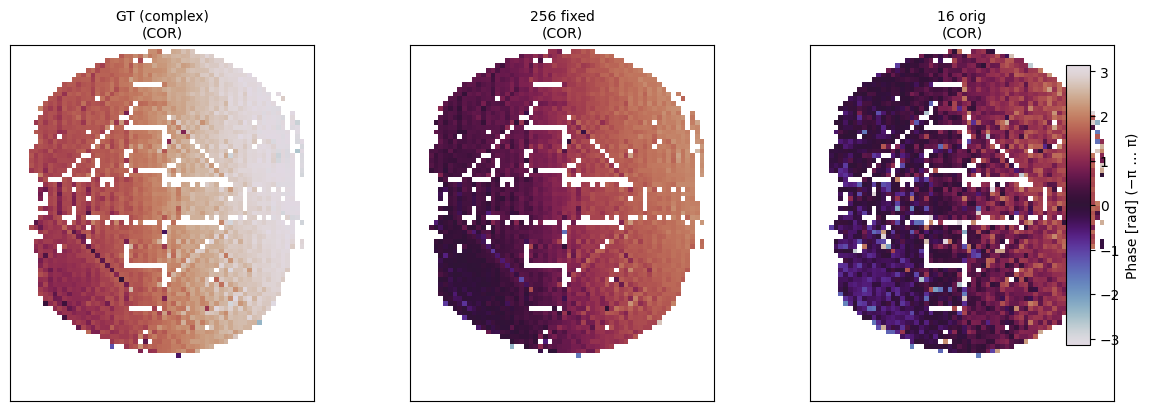

In [41]:
volumeGTscaledmasked_NA256f, params = flatten_phase_linear_3d(
    volumeGTscaledmasked_NA256,
    target_c=vol5_R2,#volumeGTscaledmasked_NA8,   # optional reference
    mask_frac=0.18,                       # start slightly higher to trust only strong signal
    max_iters=100,                         # slow refinement
    step=0.1,                             # small correction per iteration (10%)
    weight_power=2.0,                     # emphasize strong voxels (|mag|^2 weighting)
    mask_schedule=[0.08, 0.07, 0.06, 0.05, 0.04, 0.03],  # gradually include weaker voxels
    tol=1e-6                              # strict convergence
)

print("Residual slopes:", params)


volumeGTscaled_NA256f = apply_phase_ramp_3d(volumeGTscaled_NA256, params, inverse=True)

# === Your specific call ===
vols_c = [volumeGTscaledmasked_NA256, volumeGTscaledmasked_NA256f, volumeGTscaledmasked_NA8]
titles = ["GT (complex)", '256 fixed', '16 orig']

fig_phase = plot_phase_grid(vols_c, titles, slc=slc, mask_frac=0.01)
# fig_phase.savefig(f'export_figs/phase_maps_slice{slc:03d}.pdf', bbox_inches='tight', dpi=300)
plt.show()

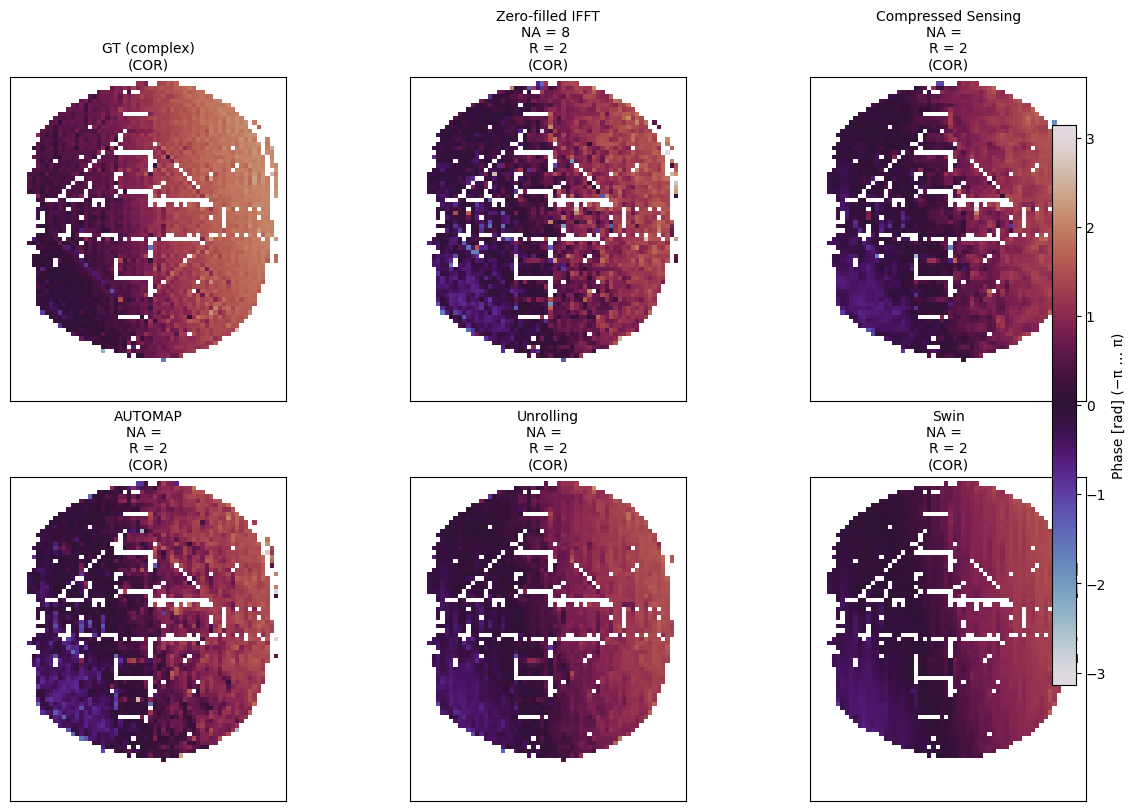

In [42]:
# # === Your specific call ===
vols_c = [volumeGTscaledmasked_NA256f, vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2]
titles = ["GT (complex)", vol1title, vol2title, vol3title, vol4title, vol5title]

fig_phase = plot_phase_grid(vols_c, titles, slc=slc, mask_frac=0.05)
# fig_phase.savefig(f'export_figs/phase_maps_slice{slc:03d}.pdf', bbox_inches='tight', dpi=300)
plt.show()

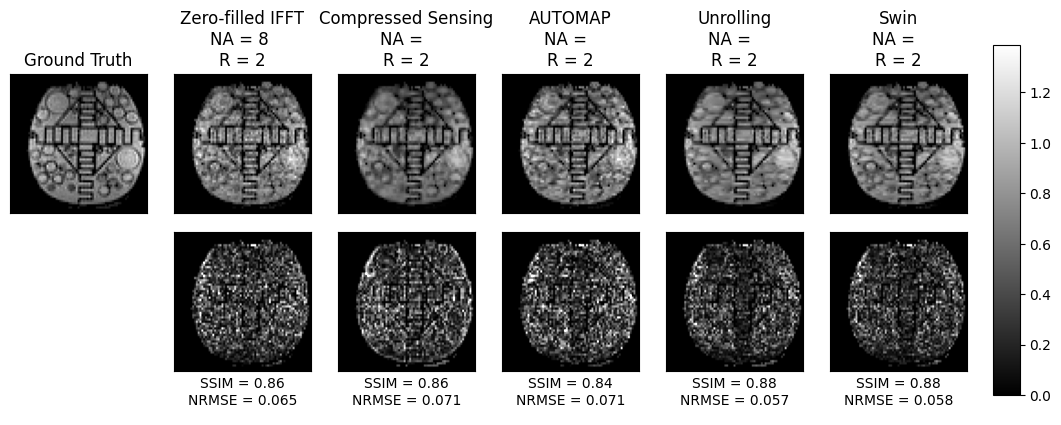

Difference Maps are scaled by 3


In [43]:
import importlib
import display_fns  # or your full module path if needed, e.g., pt_Unrolling.SwinCascade.swin_recon_3d

importlib.reload(display_fns)

from display_fns import compare_n_plot

fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked_NA256,
    volumes=[vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

#fig_comp.savefig('export_figs/hidden_noise_NA256.pdf', bbox_inches='tight', dpi=300)

In [44]:
# Example prints
print("\n--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---")
print(f"KCE_rel (Zero-fill):           {kce_rel_to_zf(volifftrecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (Compressed Sensing):  {kce_rel_to_zf(volcsrecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (AUTOMAP):             {kce_rel_to_zf(volamaprecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (Unrolled Network):    {kce_rel_to_zf(volunrollrecon, volumeGTscaled_NA256f, mask):.4f}")
print(f"KCE_rel (Swin):                {kce_rel_to_zf(volswinrecon, volumeGTscaled_NA256f, mask):.4f}")


--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---
KCE_rel (Zero-fill):           1.0000
KCE_rel (Compressed Sensing):  0.9637
KCE_rel (AUTOMAP):             1.1991
KCE_rel (Unrolled Network):    0.8680
KCE_rel (Swin):                0.8484


/tmp/ipykernel_1644278/3785520187.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M3d = np.repeat(mask_pe1pe2.astype(np.uint8)[:, None, :], RO, axis=1)


## NEX 4 as reference

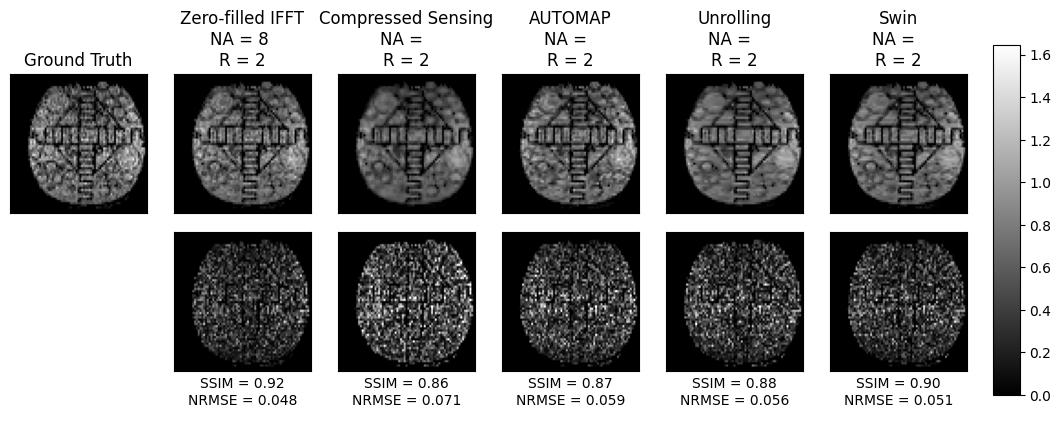

Difference Maps are scaled by 3


In [45]:
import importlib
import display_fns  # or your full module path if needed, e.g., pt_Unrolling.SwinCascade.swin_recon_3d

importlib.reload(display_fns)

from display_fns import compare_n_plot



fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked_NA8,
    volumes=[vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2],
    titles=[vol1title, vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

fig_comp.savefig('export_figs/hidden_noise_NA16.pdf', bbox_inches='tight', dpi=300)

In [46]:
# Example prints
print("\n--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---")
print(f"KCE_rel (Zero-fill):           {kce_rel_to_zf(volifftrecon, volumeGTscaled_NA8, mask):.4f}")
print(f"KCE_rel (Compressed Sensing):  {kce_rel_to_zf(volcsrecon, volumeGTscaled_NA8, mask):.4f}")
print(f"KCE_rel (AUTOMAP):             {kce_rel_to_zf(volamaprecon, volumeGTscaled_NA8, mask):.4f}")
print(f"KCE_rel (Unrolled Network):    {kce_rel_to_zf(volunrollrecon, volumeGTscaled_NA8, mask):.4f}")
print(f"KCE_rel (Swin):                {kce_rel_to_zf(volswinrecon, volumeGTscaled_NA8, mask):.4f}")


--- K-space Completion Error (ZF-normalized; ZF ≡ 1.0) ---
KCE_rel (Zero-fill):           1.0000
KCE_rel (Compressed Sensing):  0.9643
KCE_rel (AUTOMAP):             1.0580
KCE_rel (Unrolled Network):    0.8917
KCE_rel (Swin):                0.8563


/tmp/ipykernel_1644278/3785520187.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M3d = np.repeat(mask_pe1pe2.astype(np.uint8)[:, None, :], RO, axis=1)


In [49]:
import numpy as np
from skimage.filters import sobel_h, sobel_v

def tenengrad_volume_3d(
    volume: np.ndarray,
    axis: int = -1,
    clip_percentiles: tuple | None = None,
):
    """
    Slice-wise Tenengrad (Sobel gradient energy) for a 3D MRI volume.

    Parameters
    ----------
    volume : np.ndarray
        3D complex or real array with shape (D, H, W) in any orientation.
        Complex inputs are converted to magnitude with np.abs.
    axis : int, default -1
        Axis along which to slice/average (0, 1, or 2).
    clip_percentiles : (float, float) or None
        Optional robust intensity clipping BEFORE global normalization, e.g. (1, 99).

    Returns
    -------
    mean_score : float
        Mean Tenengrad across valid slices (higher = sharper / more edges).
    std_score : float
        Standard deviation across valid slices.
    per_slice_scores : np.ndarray
        Tenengrad for each slice (np.nan where invalid).
    """
    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {volume.shape}")

    # complex -> magnitude
    vol = np.abs(volume).astype(np.float32)

    # Optional robust clipping across the whole volume
    if clip_percentiles is not None:
        p_lo, p_hi = np.percentile(vol, clip_percentiles)
        if p_hi > p_lo:
            vol = np.clip(vol, p_lo, p_hi)

    # Global min-max normalization to [0,1]
    vmin, vmax = float(np.nanmin(vol)), float(np.nanmax(vol))
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
        S = vol.shape[axis]
        return np.nan, np.nan, np.full(S, np.nan, dtype=float)
    vol = (vol - vmin) / (vmax - vmin + 1e-12)

    # Reorder so chosen axis is first: (S, H, W)
    vol_slices = np.moveaxis(vol, axis, 0)
    S = vol_slices.shape[0]
    scores = np.full(S, np.nan, dtype=float)

    for i in range(S):
        sl = vol_slices[i]
        if sl.ndim != 2 or sl.size == 0 or not np.isfinite(sl).all():
            continue
        if sl.max() <= sl.min():
            # constant slice after normalization
            continue

        gx = sobel_h(sl)
        gy = sobel_v(sl)
        grad_mag_sq = gx * gx + gy * gy
        # Mean gradient energy = Tenengrad
        scores[i] = float(np.mean(grad_mag_sq))

    valid = np.isfinite(scores)
    if not np.any(valid):
        return np.nan, np.nan, scores
    return float(np.nanmean(scores[valid])), float(np.nanstd(scores[valid])), scores


In [50]:
# Example prints
print("\n--- Reference-independent Perceptual Quality (BRISQUE; lower = better) ---")
print(f"BRISQUE (Ground Truth256):        {brisque_volume_3d(volumeGTscaled_NA256, axis=2)[0]:.2f}")
print(f"BRISQUE (Ground Truth 16):        {brisque_volume_3d(volumeGTscaled_NA16, axis=2)[0]:.2f}")
print(f"BRISQUE (Zero-fill):           {brisque_volume_3d(volifftrecon, axis=2)[0]:.2f}")
print(f"BRISQUE (Compressed Sensing):  {brisque_volume_3d(volcsrecon, axis=2)[0]:.2f}")
print(f"BRISQUE (AUTOMAP):             {brisque_volume_3d(volamaprecon, axis=2)[0]:.2f}")
print(f"BRISQUE (Unrolled Network):    {brisque_volume_3d(volunrollrecon, axis=2)[0]:.2f}")
print(f"BRISQUE (Swin Transformer):    {brisque_volume_3d(volswinrecon, axis=2)[0]:.2f}")


--- Reference-independent Perceptual Quality (BRISQUE; lower = better) ---
BRISQUE (Ground Truth256):        13.49
BRISQUE (Ground Truth 16):        72.91
BRISQUE (Zero-fill):           44.51
BRISQUE (Compressed Sensing):  6.05
BRISQUE (AUTOMAP):             45.29
BRISQUE (Unrolled Network):    17.49
BRISQUE (Swin Transformer):    24.88


In [51]:
print("\n--- Reference-independent Sharpness (Tenengrad; higher = sharper) ---")
print(f"Tenengrad (Ground Truth256):     {tenengrad_volume_3d(volumeGTscaled_NA256, axis=2)[0]:.4f}")
print(f"Tenengrad (Ground Truth 16):     {tenengrad_volume_3d(volumeGTscaled_NA16,  axis=2)[0]:.4f}")
print(f"Tenengrad (Zero-fill):           {tenengrad_volume_3d(volifftrecon,       axis=2)[0]:.4f}")
print(f"Tenengrad (Compressed Sensing):  {tenengrad_volume_3d(volcsrecon,         axis=2)[0]:.4f}")
print(f"Tenengrad (AUTOMAP):             {tenengrad_volume_3d(volamaprecon,       axis=2)[0]:.4f}")
print(f"Tenengrad (Unrolled Network):    {tenengrad_volume_3d(volunrollrecon,     axis=2)[0]:.4f}")
print(f"Tenengrad (Swin Transformer):    {tenengrad_volume_3d(volswinrecon,       axis=2)[0]:.4f}")



--- Reference-independent Sharpness (Tenengrad; higher = sharper) ---
Tenengrad (Ground Truth256):     0.0268
Tenengrad (Ground Truth 16):     0.0250
Tenengrad (Zero-fill):           0.0173
Tenengrad (Compressed Sensing):  0.0144
Tenengrad (AUTOMAP):             0.0202
Tenengrad (Unrolled Network):    0.0183
Tenengrad (Swin Transformer):    0.0195
